In [31]:
#have the dataframes all at once 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import os

def process_file(file):
    col_names = ["Index", "DateD", "DateM", "DateY", "Time", "MonStatus", "Extras", "MonN", "TubeN", "DataType", "Unused", "Light"]
    
    for i in range(1, 33):
        col_names.append(f"Sp{i}")
    
    df = pd.read_csv(file, names=col_names, sep='\s+', header=None)
    df = df.set_index('Index')
    df['Time'] = pd.to_datetime(df['Time'], format='%H:%M:%S', errors='coerce')
    df = df[df["MonStatus"] == 1]

    month_map = {'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4, 'May': 5, 'Jun': 6}
    df['DateM'] = df['DateM'].str[:3].map(month_map)
    df['DateY'] = df['DateY'].apply(lambda x: int(str(20) + str(x)))
    df['Date'] = pd.to_datetime(dict(year=df['DateY'], month=df['DateM'], day=df['DateD']), errors='coerce')

    df['Time'] = pd.to_datetime(dict(year=df['Date'].dt.year,
                                     month=df['Date'].dt.month,
                                     day=df['Date'].dt.day,
                                     hour=df['Time'].dt.hour,
                                     minute=df['Time'].dt.minute,
                                     second=df['Time'].dt.second))

    df = df.drop(["DateD", "DateM", "DateY", "Date", "MonStatus", "Extras", "MonN", "TubeN", "DataType", "Unused"], axis=1)

    day_map = {day: idx+1 for idx, day in enumerate(df['Time'].dt.day.unique())}

    df.insert(0, 'Day', df['Time'].dt.day.map(day_map))
    
    return df

def process_files(files):
    dataframes = {}
    for idx, file in enumerate(files, start=1):
        df = process_file(file)
        dataframes[f'df{idx}'] = df
    return dataframes

files = ['StA LD-DD 0118-0201-2024-Copy1.txt']

dataframes = process_files(files)
for name, df in dataframes.items():
    print(f"{name}:")
    display(df)

df1:


,Day,Time,Light,Sp1,Sp2,Sp3,Sp4,Sp5,Sp6,Sp7,...,Sp23,Sp24,Sp25,Sp26,Sp27,Sp28,Sp29,Sp30,Sp31,Sp32
Index,,,,,,,,,,,,,,,,,,,,,
1,1,2024-01-18 13:17:00,1,2,2,15,9,12,10,17,...,6,6,4,0,0,0,0,0,0,0
2,1,2024-01-18 13:18:00,1,0,0,0,0,1,0,1,...,1,0,0,0,0,0,0,0,0,0
3,1,2024-01-18 13:19:00,1,0,0,0,0,1,0,2,...,3,0,20,0,0,0,0,0,0,0
4,1,2024-01-18 13:20:00,1,0,0,0,4,3,0,1,...,0,0,9,0,0,0,0,0,0,0
5,1,2024-01-18 13:21:00,1,0,0,0,3,3,0,0,...,0,0,2,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20417,15,2024-02-01 17:33:00,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
20418,15,2024-02-01 17:34:00,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
20419,15,2024-02-01 17:35:00,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
import pandas as pd
from scipy.stats import ttest_1samp

# Assuming your data is in a DataFrame 'df' with columns 'spider_id', 'day', 'activity_counts', 'light_transition_time'

# Step 1: Identify activity onset
activity_onsets = []
for spider_id, spider_data in df.groupby('spider_id'):
    for day, day_data in spider_data.groupby('day'):
        # Find the time when activity count crosses a threshold (e.g., 10)
        onset_time = day_data[day_data['activity_counts'] > 10].index[0]
        activity_onsets.append({'spider_id': spider_id, 'day': day, 'onset_time': onset_time})

activity_onsets_df = pd.DataFrame(activity_onsets)

# Step 2: Calculate anticipation
activity_onsets_df['anticipation'] = activity_onsets_df['onset_time'] - df[['spider_id', 'day', 'light_transition_time']].set_index(['spider_id', 'day'])['light_transition_time']

# Step 3: Test for significance
anticipation_values = activity_onsets_df.groupby('spider_id')['anticipation'].apply(lambda x: x.values)

for spider_id, anticipations in anticipation_values.items():
    t_stat, p_val = ttest_1samp(anticipations, 0)
    if p_val < 0.05:
        print(f"Spider {spider_id} is entrained (p-value = {p_val:.4f})")
    else:
        print(f"Spider {spider_id} is not entrained (p-value = {p_val:.4f})")

In [12]:
import pandas as pd
import numpy as np
from scipy.stats import ttest_1samp

# Assuming your DataFrame is named 'df'
# First, let's melt the DataFrame to make it easier to work with
df_melted = df.melt(id_vars=['Day', 'Time', 'Light'], 
                    var_name='Spider', 
                    value_name='Activity')

# Convert 'Time' to datetime if it's not already
df_melted['Time'] = pd.to_datetime(df_melted['Time'])

# Function to find activity onset
def find_onset(group, threshold=10):
    # Find the first time activity exceeds the threshold
    onset = group[group['Activity'] > threshold]['Time'].min()
    return onset if pd.notnull(onset) else None

# Function to find light transition
def find_light_transition(group):
    # Find the time when light changes from 0 to 1 or 1 to 0
    transition = group[group['Light'] != group['Light'].shift()]['Time'].min()
    return transition if pd.notnull(transition) else None

# Group by Day and Spider, then find onset for each group
onsets = df_melted.groupby(['Day', 'Spider']).apply(find_onset).reset_index()
onsets.columns = ['Day', 'Spider', 'Onset']

# Find light transitions for each day
light_transitions = df_melted.groupby('Day').apply(find_light_transition).reset_index()
light_transitions.columns = ['Day', 'LightTransition']

# Merge onsets and light transitions
results = pd.merge(onsets, light_transitions, on='Day')

# Calculate anticipation (in minutes)
results['Anticipation'] = (results['Onset'] - results['LightTransition']).dt.total_seconds() / 60

# Perform t-test for each spider
for spider in results['Spider'].unique():
    spider_data = results[results['Spider'] == spider]['Anticipation']
    if len(spider_data) > 1 and spider_data.std() > 0:  # Check for at least 2 values and non-zero variance
        t_stat, p_val = ttest_1samp(spider_data, 0)
        if p_val < 0.05:
            print(f"{spider} is entrained (p-value = {p_val:.4f})")
        else:
            print(f"{spider} is not entrained (p-value = {p_val:.4f})")
    else:
        print(f"Not enough data or no variance for {spider}")

display(df_melted)

Not enough data or no variance for Sp1
Sp10 is not entrained (p-value = nan)
Sp11 is not entrained (p-value = nan)
Sp12 is entrained (p-value = 0.0000)
Sp13 is not entrained (p-value = nan)
Sp14 is not entrained (p-value = nan)
Sp15 is not entrained (p-value = nan)
Sp16 is not entrained (p-value = nan)
Sp17 is entrained (p-value = 0.0002)
Sp18 is not entrained (p-value = nan)
Sp19 is not entrained (p-value = nan)
Not enough data or no variance for Sp2
Not enough data or no variance for Sp20
Sp21 is entrained (p-value = 0.0000)
Sp22 is not entrained (p-value = nan)
Sp23 is not entrained (p-value = nan)
Not enough data or no variance for Sp24
Sp25 is entrained (p-value = 0.0003)
Not enough data or no variance for Sp26
Not enough data or no variance for Sp27
Not enough data or no variance for Sp28
Not enough data or no variance for Sp29
Sp3 is not entrained (p-value = nan)
Not enough data or no variance for Sp30
Not enough data or no variance for Sp31
Not enough data or no variance for Sp

,Day,Time,Light,Spider,Activity
0,1,2024-01-18 13:17:00,1,Sp1,2
1,1,2024-01-18 13:18:00,1,Sp1,0
2,1,2024-01-18 13:19:00,1,Sp1,0
3,1,2024-01-18 13:20:00,1,Sp1,0
4,1,2024-01-18 13:21:00,1,Sp1,0
...,...,...,...,...,...
653467,15,2024-02-01 17:33:00,0,Sp32,0
653468,15,2024-02-01 17:34:00,0,Sp32,0
653469,15,2024-02-01 17:35:00,0,Sp32,0
653470,15,2024-02-01 17:36:00,0,Sp32,0


In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

df = dataframes['df1']
df['Time'] = pd.to_datetime(df['Time'])
light_column = df['Light']
difference = np.diff(light_column)
df['Light2'] = np.append(difference, np.nan)

def find_activity_onset(activity_data, light_off_time, window_size=60, threshold=2):
    post_light_off = activity_data[activity_data.index > light_off_time].iloc[:180]
    rolling_mean = post_light_off.rolling(window=window_size, center=True).mean()
    peaks, _ = find_peaks(rolling_mean, height=rolling_mean.mean() + threshold*rolling_mean.std())
    
    if len(peaks) > 0:
        onset_time = post_light_off.index[peaks[0]]
        return (onset_time - light_off_time).total_seconds() / 60
    else:
        return np.nan

results = []
for day in df['Day'].unique():
    day_data = df[df['Day'] == day]
    light_off_time = day_data[day_data['Light2'] == 1]['Time'].iloc[1]
    
    for spider in range(1, 33):  # Spiders are numbered 1 to 32
        spider_data = day_data.set_index('Time')[f'Sp{spider}']
        onset = find_activity_onset(spider_data, light_off_time)
        results.append({'Day': day, 'Spider': f'Sp{spider}', 'Onset': onset})

results_df = pd.DataFrame(results)

# Calculate average onset for each spider
average_onsets = results_df.groupby('Spider')['Onset'].mean().sort_values()

# Visualize results
plt.figure(figsize=(12, 6))
average_onsets.plot(kind='bar')
plt.title('Average Activity Onset Time After Lights Off')
plt.xlabel('Spider')
plt.ylabel('Minutes After Lights Off')
plt.tight_layout()
plt.show()

# Print summary statistics
print(average_onsets.describe())

# Identify spiders with early and late onsets
early_onset = average_onsets[average_onsets < average_onsets.mean() - average_onsets.std()]
late_onset = average_onsets[average_onsets > average_onsets.mean() + average_onsets.std()]

print("\nSpiders with early onset:")
print(early_onset)
print("\nSpiders with late onset:")
print(late_onset)

IndexError: single positional indexer is out-of-bounds

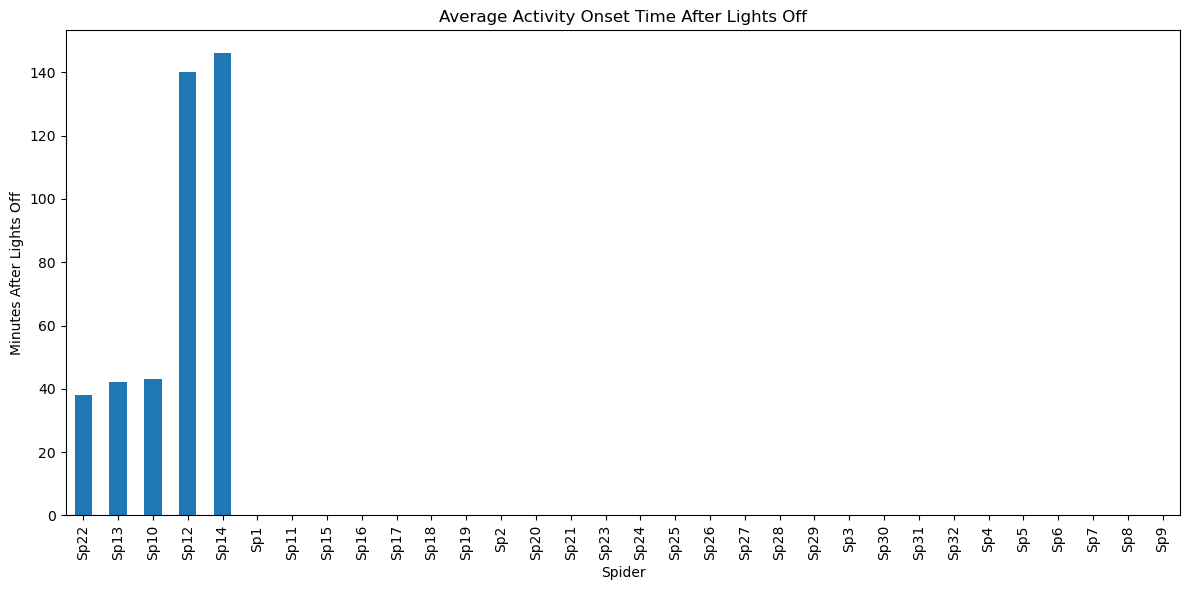

count      5.000000
mean      81.800000
std       55.939253
min       38.000000
25%       42.000000
50%       43.000000
75%      140.000000
max      146.000000
Name: Onset, dtype: float64

Spiders with early onset:
Series([], Name: Onset, dtype: float64)

Spiders with late onset:
Spider
Sp12    140.0
Sp14    146.0
Name: Onset, dtype: float64


In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

# Load the data
df = dataframes['df1']
df['Time'] = pd.to_datetime(df['Time'])

# Identify light-off times
light_off_times = {}
for day in df['Day'].unique():
    day_data = df[df['Day'] == day]
    light_off = day_data.loc[day_data['Light'].diff().ne(0) & (day_data['Light'] == 0), 'Time']
    if not light_off.empty:
        light_off_times[day] = light_off.iloc[0]
    else:
        print(f"Warning: No light-off time found for Day {day}")

# Function to find activity onset
def find_activity_onset(activity_data, light_off_time, window_size=60, threshold=2):
    if pd.isnull(light_off_time):
        return np.nan
    post_light_off = activity_data[activity_data.index > light_off_time].iloc[:180]
    if post_light_off.empty:
        return np.nan
    rolling_mean = post_light_off.rolling(window=window_size, center=True).mean()
    peaks, _ = find_peaks(rolling_mean, height=rolling_mean.mean() + threshold*rolling_mean.std())
    
    if len(peaks) > 0:
        onset_time = post_light_off.index[peaks[0]]
        return (onset_time - light_off_time).total_seconds() / 60
    else:
        return np.nan

# Analyze data for each spider
results = []
for day in df['Day'].unique():
    day_data = df[df['Day'] == day]
    light_off_time = light_off_times.get(day, pd.NaT)
    
    for spider in range(1, 33):  # Spiders are numbered 1 to 32
        spider_data = day_data.set_index('Time')[f'Sp{spider}']
        onset = find_activity_onset(spider_data, light_off_time)
        results.append({'Day': day, 'Spider': f'Sp{spider}', 'Onset': onset})

results_df = pd.DataFrame(results)

# Calculate average onset for each spider
average_onsets = results_df.groupby('Spider')['Onset'].mean().sort_values()

# Visualize results
plt.figure(figsize=(12, 6))
average_onsets.plot(kind='bar')
plt.title('Average Activity Onset Time After Lights Off')
plt.xlabel('Spider')
plt.ylabel('Minutes After Lights Off')
plt.tight_layout()
plt.show()

# Print summary statistics
print(average_onsets.describe())

# Identify spiders with early and late onsets
early_onset = average_onsets[average_onsets < average_onsets.mean() - average_onsets.std()]
late_onset = average_onsets[average_onsets > average_onsets.mean() + average_onsets.std()]

print("\nSpiders with early onset:")
print(early_onset)
print("\nSpiders with late onset:")
print(late_onset)